# Mixture Density Networks with Julia

[This post is also available as a Jupyter notebook.](https://github.com/jklaise/personal_website/tree/master/notebooks/mdn_julia.ipynb)

Related posts:

 - JavaScript [implementation](http://blog.otoro.net/2015/06/14/mixture-density-networks/).
 - TensorFlow [implementation](http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/).
 - PyTorch [implementation](https://github.com/hardmaru/pytorch_notebooks/blob/master/mixture_density_networks.ipynb)

This post is a result of me trying to understand how to do deep learning in Julia using the excellent [Flux](https://fluxml.ai/) package as well as getting a better understanding of conditional density estimation using a simple but effective technique—[Mixture Density Networks](https://publications.aston.ac.uk/id/eprint/373/1/NCRG_94_004.pdf) (Bishop, 1994). This post follows very closely the PyTorch implementation (including parahprasing some statements) listed above, which itself was adapted from the original TensorFlow and JavaScript implementations.

## Prelude: Why Julia?

If we want to do generic training of models via backpropagation we need an automatic differentiation (AD) solution—nobody has time to write their gradients by hand, you just want to define your forward pass and let the AD handle the backward pass. In Python I might use one of the big frameworks like PyTorch or TensorFlow to do this (if I'm feeling adventurous then maybe [autograd](https://github.com/HIPS/autograd) or [jax](https://github.com/google/jax) at the cost of forgoing higher-level interfaces for neural network layers, optimizers etc.). The problem with these big frameworks is that if you have some very custom model operations on the forward pass, it might be impossible for the AD to take gradients. You may be able to write your own, but it might involve hacking the underlying framework (which is most likely C++ rather than Python) without guarantees of working. A concrete example is [backpropagating through an ODE solver](https://fluxml.ai/2019/03/05/dp-vs-rl.html) to do model based reinforcement learning.

Julia has the promise of native [differentiable programming](https://fluxml.ai/2019/02/07/what-is-differentiable-programming.html) to allow just the kind of use cases. [Swift for Tensorflow](https://www.tensorflow.org/swift) is a similar endeavour, but I think Julia has the upper hand for several reasons: it has an extensive scientific package ecosystem, a flexible compiler enabling things like [source-to-source automatic differentiation](https://github.com/FluxML/Zygote.jl), and it's a solution to the [two language problem](https://thebottomline.as.ucsb.edu/2018/10/julia-a-solution-to-the-two-language-programming-problem) which can plague Python frameworks such as PyTorch and TensorFlow when it comes to writing very custom models.

## Warm-up: 1-D regression
Let's warm up by doing some very simple data fitting in 1D by using a neural network with one hidden layer. We will try to fit the sinusoidal function

$$
y(x)=7 \sin( 0.75 x ) + 0.5 x + \epsilon,
$$

where

- $7 \sin( 0.75 x)$: a large periodic sine wave.
- $0.5 x$: add a slight upward slope.
- $\epsilon$: add some standard Gaussian noise

First we import the libraries we need.

In [1]:
using Distributions
using Flux
using Plots
using Random
Random.seed!(12345); # for reproducibility

Next we define generate a sample dataset of points $(x, y(x))$ and visualize it:

In [2]:
# Flux expects batch dimension to be last
function generate_data(n_samples)
    ϵ = rand(Normal(), 1, n_samples)
    x = rand(Uniform(-10.5, 10.5), 1, n_samples)
    y = 7sin.(0.75x) + 0.5x + ϵ
    return x, y
end

n_samples = 1000
x, y = generate_data(n_samples); # semicolon to suppress output as in MATLAB

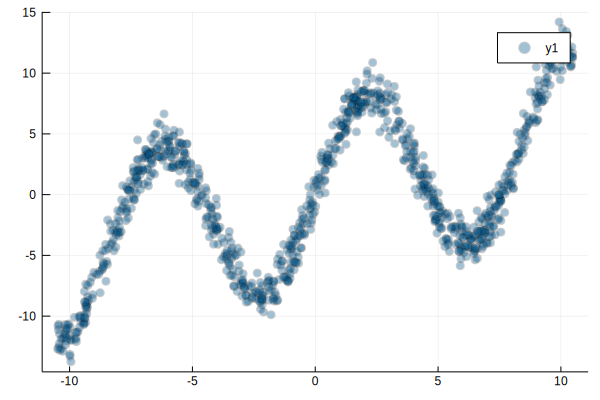

In [3]:
scatter(x', y', alpha=0.2) # transpose for plotting

We will now use this data to train a neural network with one hidden layer. The network can be described by the following equation:

$$
\hat{y}(x) = W_2\tanh(W_1x + b_1) +b_2,
$$

where

 - $W_1$, $W_2$ are the weights for the input and output layers
 - $b_1$, $b_2$ are the biases for the input and output layers
 - $\tanh$ is a the hyperbolic tangent activation function
 
Let's create this network using 20 hidden nodes. Note that both the input and output are 1-dimensional. We will use Flux's `Dense` layer constructs and the `Chain` model (equivalent to a Sequential layer in PyTorch/Tensorflow) to put these together:

In [4]:
n_input = 1
n_hidden = 20
n_output = 1

model = Chain(
    Dense(n_input, n_hidden, tanh),
    Dense(n_hidden, n_output));

To train the network we also need to define a loss function, we will use the standard mean squared error loss for regression models:

In [5]:
loss(x, y) = Flux.mse(model(x), y);

We also need an optimizer which will try to minimize the loss function at training time. We will use [RMSprop](http://ruder.io/optimizing-gradient-descent/index.html#rmsprop), included in Flux:

In [6]:
opt = RMSProp(0.01, 0.99);

We need to get the parameters from the model that are to be optimized, this can be done easily within Flux as the parameters (their values and gradients) are tracked when the model was created:

In [7]:
pars = Flux.params(model);

Finally we define the number of epochs to train for as well as a simple callback function which will allow us to monitor the training loss:

In [8]:
n_epochs = 3000
evalcb() = @show(loss(x, y));

In [9]:
data = Iterators.repeated((x, y), n_epochs);

We are now ready to train the network using Flux's high-level `train!` API:

In [10]:
# high-level
Flux.train!(loss, pars, data, opt, cb=Flux.throttle(evalcb, 1))

loss(x, y) = 27.786178261722142 (tracked)
loss(x, y) = 1.6388715090546215 (tracked)
loss(x, y) = 1.2073703558560256 (tracked)
loss(x, y) = 1.1577788900615706 (tracked)
loss(x, y) = 1.1374332946542358 (tracked)
loss(x, y) = 1.125972186878964 (tracked)


Note that we created an iterator over the data, repeating it for the number of epochs we wanted to train. Alternatively, instead of using the iterator over the data and the callback, you can write the training loop more explicitly like this:

In [11]:
# lower-level
data = [(x, y)]

for epoch = 1:n_epochs
    Flux.train!(loss, pars, data, opt)
    if epoch % 300 ==0
        l = loss(x, y)
        println("Epoch: ", epoch, " loss: ", l)
    end
end

Epoch: 300 loss: 1.119907202584983 (tracked)
Epoch: 600 loss: 1.1164263824144673 (tracked)
Epoch: 900 loss: 1.1132558815645237 (tracked)
Epoch: 1200 loss: 1.1103462810589673 (tracked)
Epoch: 1500 loss: 1.1076622679714712 (tracked)
Epoch: 1800 loss: 1.1051505375745079 (tracked)
Epoch: 2100 loss: 1.1028077831096352 (tracked)
Epoch: 2400 loss: 1.1015669029685837 (tracked)
Epoch: 2700 loss: 1.09820475794281 (tracked)
Epoch: 3000 loss: 1.0948328238785436 (tracked)


With Flux you can go down to the level of doing the gradient updates manually too, similar how you would do it in PyTorch, we will use this in the next section to update our custom loss function. At the time of writing Flux is [undergoing a change](https://github.com/FluxML/Flux.jl/pull/669) in its automatic differentiation backend which might result in some changes to the low-level API.

Now that we have trained the model, we can evaluate its performance on some test data:

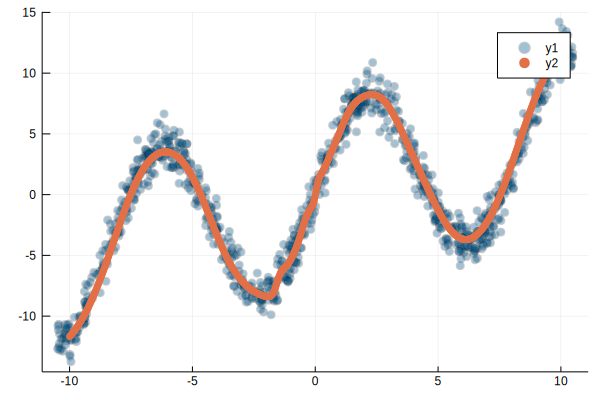

In [12]:
x_test = range(-10, stop=10, length=n_samples)
y_test = model(transpose(x_test))

scatter(transpose(x), transpose(y), alpha=0.2)
scatter!(collect(x_test), transpose(y_test.data), msc=nothing)

As we can see the network can fit this sinusoidal data quite well as expected. However, this type of fitting works well only if we are modelling a one-to-one or a many-to-one function. Suppose we inverted the training data so that the prediction task would become $x(y)$:

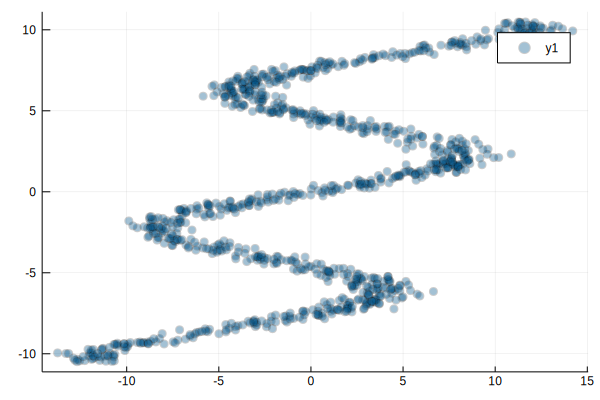

In [13]:
scatter(transpose(y), transpose(x), alpha=0.2)

Let's use the same network to try and with this inverted data:

In [14]:
n_epochs = 3000
data = Iterators.repeated((y,x), n_epochs)
Flux.train!(loss, pars, data, opt, cb=Flux.throttle(evalcb, 1))

loss(x, y) = 2.9010193330554226 (tracked)
loss(x, y) = 32.46410279730033 (tracked)
loss(x, y) = 32.73103328970853 (tracked)
loss(x, y) = 33.267277831052944 (tracked)
loss(x, y) = 33.41501919519907 (tracked)
loss(x, y) = 32.91563494169485 (tracked)


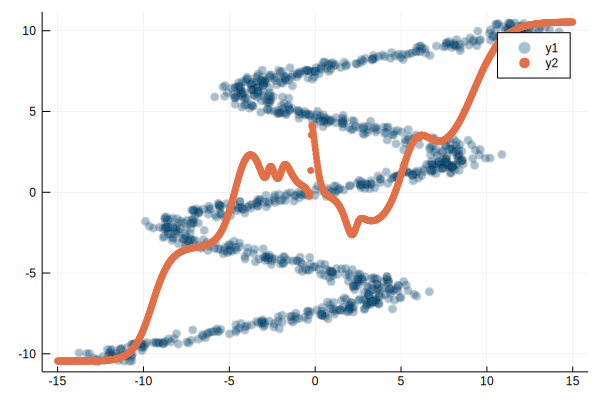

In [15]:
x_test = range(-15, stop=15, length=n_samples)
y_test = model(transpose(x_test))

scatter(transpose(y), transpose(x), alpha=0.2)
scatter!(collect(x_test), transpose(y_test.data), msc=nothing)

As we can see because we used the mean squared error as a loss function, the network models the conditional mean $\mathbb{E}[y\vert x]$ which results in predicting the average output for each input value. The main issue with this model is that it only outputs one value even though our data has multi-modal output, so we need a model which has the capacity to predict a range of output values for a given input.

### Mixture Density Networks

[Mixture Density Networks](https://publications.aston.ac.uk/id/eprint/373/1/NCRG_94_004.pdf) (Bishop, 1994) is one technique to produce multiple output values for a given input. In fact MDNs model the whole *conditional distribution* $P(y\vert x)$ which allows us to sample several possible output values for a given input. The concept is quite powerful and also allows us to calculate a sort of confidence factor in the predictions that the network is making.

The inverted sinusoid data is not just a toy problem, it's an example of an *inverse problem* that crops up all the time in fields like robotics. In fact, the original paper introducing MDNs motivated them as solving the problem of choosing the angle between a robot's arms to achieve a desired target location which can be described by an inverted sinusoid. MDNs can also be used to model handwriting where each stroke is drawn from a probability distribution of multiple possibilities rather than just sticking with one prediction. They have also been used in autonomous driving for traffic prediction.

The original implementation of MDNs uses a *Gaussian Mixture* to model the conditional distribution $P(y\vert x)$ so that for each $x$ the output is modeled by a weighted sum of Gaussians, each with different means and standard deviations:

$$
P(y\vert x) = \sum_{k=1}^{K}\pi_k(x)\phi(y, \mu_k(x), \sigma_k(x)),
$$
where

 - $k$ is indexing the individual Gaussian components of which there are $K$ in total
 - $\pi_k$ are the weights or *mixing coefficients*
 - $\phi$ is the univariate Gaussian probability density function
 - $\mu_k, \sigma_k$ are the parameters of each Gaussian
Note that $\pi_k(x),\mu_k(x),\sigma_k(x)$ are all functions of the input $x$.

To ensure that $P(y\vert x)$ is a valid probability density function, we must ensure that the mixing coefficients satisfy $\sum_{k=1}^{K}\pi_k(x)=1$ and $0\leq\pi_k(x)\leq 1$.

We will use a neural network to learn the functions $\pi_k(x),\mu_k(x),\sigma_k(x)$ which will determine the conditional density $P(y\vert x)$ from which we can then sample. In our implementation we will again use a neural network with one hidden layer of 20 nodes. We will use a mixture of 5 Gaussians so that the network will have 15 outputs (3 for each Gaussian) in total.

First, as before we compute the values of the hidden layer from the input $x$:

$$
z_h(x) = \tanh(W_1x + b_1)
$$

Then we use the values of the hidden layer to compute three sets of network outputs:

$$\begin{aligned}z_\pi &= W_\pi z_h+b_\pi \\\ z_\sigma &= W_\sigma z_h+b_\sigma \\\ z_\mu &= W_\mu z_h+b_\mu,\end{aligned}$$
where all of these outputs are vectors of length $K$. Finally we use these outputs to determine the parameters of our Gaussians:

$$\begin{aligned}\pi &= \frac{\exp(z_\pi)}{\sum\exp(z_\pi)} \\\ \sigma &= \exp(z_\sigma) \\\ \mu &= z_\mu,\end{aligned}$$
where again these are all vectors of length $K$ containing the parameter estimates of each of the Gaussians. Note that because of the constraints on $\pi_k(x)$ we used the softmax function and to ensure that $\sigma_k(x)\geq 0$ we used the exponential function. There are no restrictions on the values of $\mu_k(x)$ so we just use the network outputs directly.

We can now write this in code as follows:

In [16]:
n_gaussians = 5
n_hidden = 20;

In [17]:
z_h = Dense(1, n_hidden, tanh)
z_π = Dense(n_hidden, n_gaussians)
z_σ = Dense(n_hidden, n_gaussians, exp)
z_μ = Dense(n_hidden, n_gaussians);

In [18]:
pi = Chain(z_h, z_π, softmax)
sigma = Chain(z_h, z_σ)
mu = Chain(z_h, z_μ);

We cannot use the mean squared loss function anymore as our output is no longer a single value but rather the description of an entire probability distribution. Instead we can minimize the negative log-likelihood:

$$
\mathrm{loss}(y\vert x) = -\log\left(\sum_{k=1}^K\pi_k(x)\phi(y, \mu_k(x), \sigma_k(x))\right)
$$

So for every datapoint $(x, y)$ in the training data we can compute this loss function based on the predicted distribution versus the actual distribution and attempt to minimise the sum of all the losses combined.

We need to implement this loss function ourselves:

In [19]:
function gaussian_distribution(y, μ, σ)
    # periods are used for element-wise operations
    result = 1 ./ ((sqrt(2π).*σ)).*exp.(-0.5((y .- μ)./σ).^2)
end;

In [20]:
function mdn_loss(π, σ, μ, y)
    result = π.*gaussian_distribution(y, μ, σ)
    result = sum(result, dims=1)
    result = -log.(result)
    return mean(result)
end;

Next, we collect the trainable parameters, define an optimizer (this time we use [ADAM](http://ruder.io/optimizing-gradient-descent/index.html#adam)) and the number of epochs—we will need to train longer for this network to converge.

In [21]:
pars = Flux.params(pi, sigma, mu)
opt = ADAM()
n_epochs = 8000;

Finally we write the training loop. We will use the low-level Flux API for manually updating gradients to accommodate our custom loss function:

In [22]:
# lowest-level?
data = [(y, x)]

for epoch = 1:n_epochs
    
    # forward
    pi_out = pi(y)
    sigma_out = sigma(y)
    mu_out = mu(y)
    l = mdn_loss(pi_out, sigma_out, mu_out, x)
    
    # backward
    Tracker.back!(l)
    for p in pars
        Tracker.update!(opt, p, Tracker.grad(p))
    end

    if epoch % 1000 == 0
        println("Epoch: ", epoch, " loss: ", l)
    end
end

Epoch: 1000 loss: 2.473710913502871 (tracked)
Epoch: 2000 loss: 2.0019056556897907 (tracked)
Epoch: 3000 loss: 1.6021284357242676 (tracked)
Epoch: 4000 loss: 1.4696624904817952 (tracked)
Epoch: 5000 loss: 1.3973814954751895 (tracked)
Epoch: 6000 loss: 1.3539807297063875 (tracked)
Epoch: 7000 loss: 1.314270425005812 (tracked)
Epoch: 8000 loss: 1.2856571105506072 (tracked)


As a side note, we used Flux's internal automatic differentiation backend to automatically calculate gradients of our loss. For this model there actually exist optimized gradient expressions which could be used to optimize the training (see derivations in the [original paper](https://publications.aston.ac.uk/id/eprint/373/1/NCRG_94_004.pdf), equations 33-39, or in the book *Pattern Recognition and Machine Learning* (Bishop, 2006), equations 5.155-5.157).

Once the training is finished we can observe the parameters of all the Gaussians and how they with respect to the input $x$:

In [23]:
x_test = range(-15, stop=15, length=n_samples)
pi_data = pi(transpose(collect(x_test)))
sigma_data = sigma(transpose(collect(x_test)))
mu_data = mu(transpose(collect(x_test)));

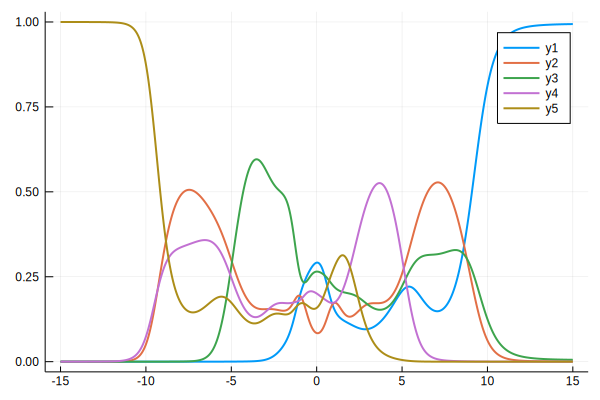

In [24]:
plot(collect(x_test), transpose(pi_data.data), lw=2)

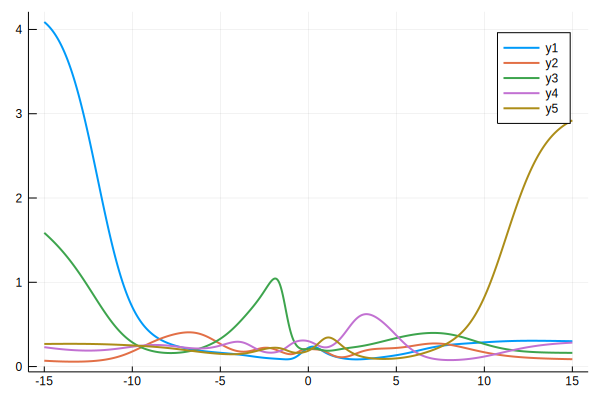

In [25]:
plot(collect(x_test), transpose(sigma_data.data), lw=2)

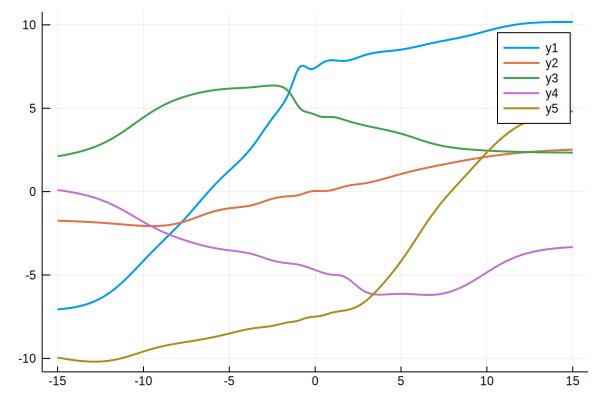

In [26]:
plot(collect(x_test), transpose(mu_data.data), lw=2)

We can also plot the mean $\mu_k(x)$ for each Gaussian together with the range $\mu_k(x)\pm\sigma_k(x)$:

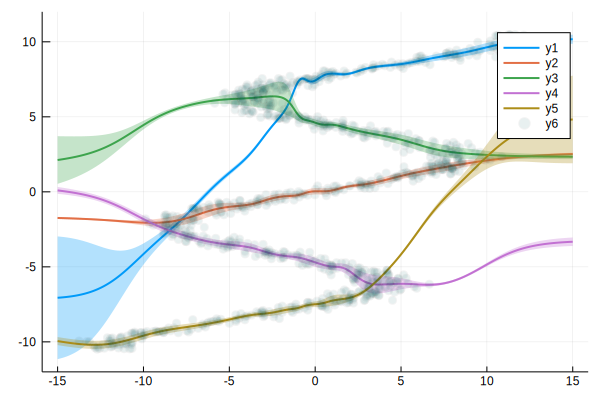

In [27]:
plot(collect(x_test), transpose(mu_data.data), lw=2, ribbon=transpose(sigma_data.data),
    ylim=(-12,12), fillalpha=0.3)
scatter!(transpose(y), transpose(x), alpha=0.05)

Let's unpack this plot:

- We see that for every input $x$ there are $K$ states where $y$ might be and we select these states with probability $\pi_k(x)$.
- The network has managed to learn that the most natural correspondence between the 5 Gaussian components and the data is to "assign" one component to each of the 5 branches/modes of the inverted sinusoid. This won't always be the case, you might get a solution whose mean components "jump" between the branches (you can see this happening here already), these solutions have comparable likelihood. 
- The standard deviations can tell us that a single component might be responsible for more than one mode of the data (e.g. middle of component $3$ (green), but this needs to be checked with the learnt mixing components (e.g. $\pi_1$ and $\pi_5$ are practically zero in the regions of high standard deviation for components $1$ (blue) and $5$ (yellow) respectively).
- We could achieve a lower loss by using more Gaussians but the results would then be less visually interpretable.

If we want to sample from the learnt probability distribution we need to pick a particular Gaussian $k$ and then sample from it using its parameters $\mu_k(x),\sigma_k(x)$. Here we use the [Gumbel max trick](http://timvieira.github.io/blog/post/2014/07/31/gumbel-max-trick/) to pick the $k$:

In [28]:
function gumbel_sample(x)
    z = rand(Gumbel(), size(x))
    return argmax(log.(x) + z, dims=1)
end

k = gumbel_sample(pi_data.data);

Now that we have selected the $k$ for each $x$, we can select the corresponding $\mu_k(x),\sigma_k(x)$ and sample from the Gaussian:

In [29]:
sampled = rand(Normal(),1, 1000).*sigma_data.data[k] + mu_data.data[k];

With these sampled values we can superimpose them on the original training distribution to visually assess the performance of the model:

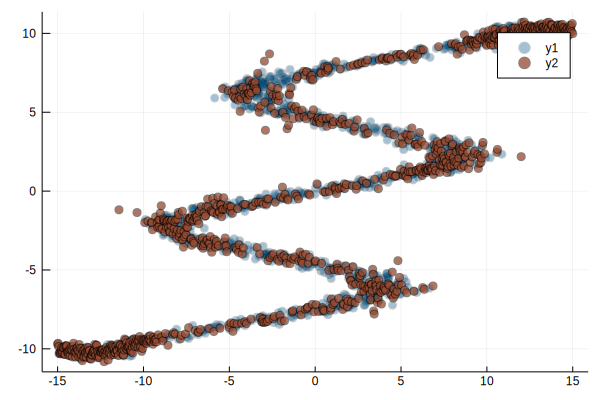

In [30]:
scatter(transpose(y), transpose(x), alpha=0.2)
scatter!(collect(x_test), transpose(sampled), alpha=0.5)

Apart from a few outliers it seems that the model has learnt the conditional distribution quite well!

## Closing thoughts

 - MDNs are a a flexible and a relatively straightforward technique to implement for modelling data following a one-to-many or many-to-many relationship.
 - Flux provides a series of thin abstractions and a fast automatic differentiation backend which makes writing custom models a breeze.
 - I'm excited about the future of machine learning and differentiable programming with Julia and hope that at least for research based work the benefits of Julia over a Python framework will become more apparent.